# Deep One-Class Classification with MinMaxScaler


**This code template is for Anomaly detection/outlier analysis using the Deep One-Class Classification. This template utilizes implementation from the pyod library along with feature scaling using MinMaxScaler.**

### Required Packages

In [19]:
!pip install plotly
!pip install pyod
!pip install tensorflow #For DeepSVDD

In [2]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from pyod.models.deep_svdd import DeepSVDD
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

2021-09-15 11:19:23.875774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Initialization

Filepath of CSV file

In [3]:
#filepath
file_path=""

List of features which are  required for model training .

In [4]:
#x_values
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path) #reading file
df.head()#displaying initial entries

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
print('Number of rows are :',df.shape[0], ',and number of columns are :',df.shape[1])

Number of rows are : 303 ,and number of columns are : 14


In [7]:
df.columns.tolist()


['age',
 'sex',
 'cp',
 'trtbps',
 'chol',
 'fbs',
 'restecg',
 'thalachh',
 'exng',
 'oldpeak',
 'slp',
 'caa',
 'thall',
 'output']

### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [8]:
#spliting data into X(features) 

X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [9]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.

In [10]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
X.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2



### Data Scaling
**Used MinMaxScaler**

* Transform features by scaling each feature to a given range.

* This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [11]:
X_Scaled=MinMaxScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667


### Data Splitting
The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [12]:
x_train,x_test=train_test_split(X_Scaled,test_size=0.2,random_state=123) #performing datasplitting

## Model

Deep One-Class Classifier with AutoEncoder (AE) is a type of neural networks for learning useful data representations in an unsupervised way. DeepSVDD trains a neural network while minimizing the volume of a hypersphere that encloses the network representations of the data, forcing the network to extract the common factors of variation

**Tuning parameters :**

* c (float, optional (default='forwad_nn_pass'))

Deep SVDD center, the default will be calculated based on network initialization first forward pass. To get repeated results set random_state if c is set to None.

* use_ae (bool, optional (default=False)

The AutoEncoder type of DeepSVDD it reverse neurons from hidden_neurons if set to True.

* hidden_neurons (list, optional (default=[64, 32]))

The number of neurons per hidden layers. if use_ae is True, neurons will be reversed eg. [64, 32] -> [64, 32, 32, 64, n_features]

* hidden_activation (str, optional (default='relu'))

Activation function to use for hidden layers. All hidden layers are forced to use the same type of activation. See https://keras.io/activations/

* output_activation (str, optional (default='sigmoid'))

Activation function to use for output layer. See https://keras.io/activations/

* optimizer (str, optional (default='adam'))

* String (name of optimizer) or optimizer instance. See https://keras.io/optimizers/

* epochs (int, optional (default=100))

Number of epochs to train the model.

* batch_size (int, optional (default=32))

Number of samples per gradient update.

* contamination (float in (0., 0.5), optional (default=0.1))

The amount of contamination of the data set, i.e. the proportion of outliers in the data set. When fitting this is used to define the threshold on the decision function.



In [13]:
model = DeepSVDD(contamination=0.3, epochs=10, batch_size=16)
model.fit(x_train)

2021-09-15 11:19:27.824681: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 11:19:27.826831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 11:19:27.865584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 11:19:27.866275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-15 11:19:27.866338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-15 11:19:27.866414: I tensorflow/stream_executor/platform/def

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
net_output (Dense)           (None, 32)                2080      
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 32)                0         
_________________________________________________________________
tf.math.pow_1 (TFOpLambda)   (None, 32)                0         
_________________________________________________________________
tf.math.reduce_sum_1 (TFOpLa (None,)                   0         
_________________________________________________________________
tf.math.reduce_mean_1 (TFOpL ()                        0   

DeepSVDD(batch_size=16,
     c=array([0.1    , 0.90371, 0.1    , 0.20217, 0.26064, 0.1    , 0.34458,
       0.26999, 0.18431, 0.45032, 0.1    , 0.19643, 0.1    , 0.     ,
       0.1    , 0.1    , 0.1    , 0.1    , 0.1    , 0.22615, 0.32998,
       0.1    , 0.3069 , 0.17255, 0.1    , 0.10363, 0.1    , 0.26982,
       0.22149, 0.1    , 0.42559, 0.1    ], dtype=float32),
     contamination=0.3, dropout_rate=0.2, epochs=10,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=True,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

### Anomaly Prediction

In [14]:
result=x_test.copy(deep=True)
result['Anomaly']=model.predict(x_test)
result.head()


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,Anomaly
11,0.395833,0.0,0.666667,0.339623,0.340183,0.0,0.5,0.519084,0.0,0.032258,1.0,0.0,0.666667,0
292,0.604167,0.0,0.000000,0.716981,0.226027,1.0,0.0,0.572519,1.0,0.451613,0.5,0.5,0.333333,1
269,0.562500,1.0,0.000000,0.339623,0.358447,1.0,0.0,0.244275,1.0,0.258065,0.0,0.0,1.000000,1
268,0.520833,1.0,0.000000,0.264151,0.365297,0.0,0.0,0.343511,1.0,0.516129,0.5,0.5,0.666667,0
94,0.333333,0.0,0.333333,0.169811,0.077626,0.0,0.5,0.511450,0.0,0.000000,0.5,0.0,0.666667,0


### Anomaly Visualization
#### Bar Plot

<AxesSubplot:>

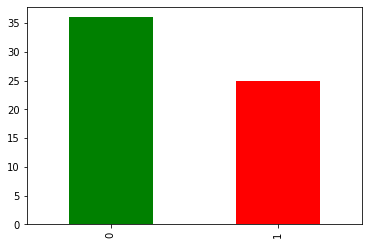

In [15]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [16]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate')
fig.show()

### Anomalies
In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [17]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

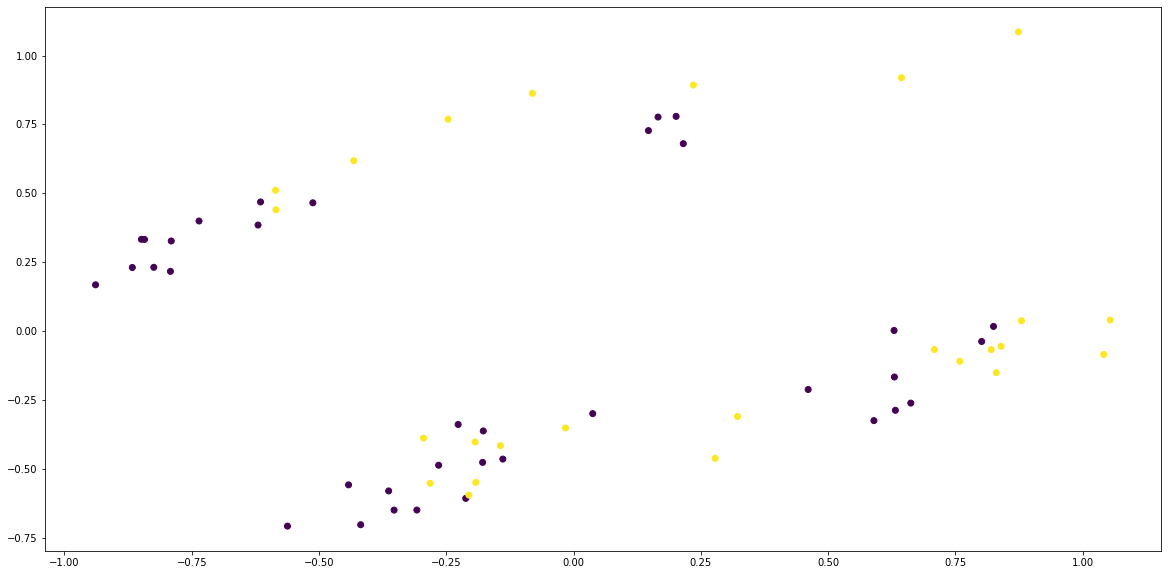

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Vipin Kumar , Github: [Profile](https://github.com/devVipin01)